## Import libraries

In [1]:
import PIL
import torch
import sys
import boto3
import io
import numpy as np

from vizer.draw import draw_boxes

sys.path.append('SSD')
from ssd.config import cfg
from ssd.data.transforms import build_transforms
from ssd.modeling.detector import build_detection_model

SSD/ssd/utils/nms.py:15: UserWarning: You are using python version NMS, which is very very slow. Try compile c++ NMS using `cd ext & python build.py build_ext develop`
  warnings.warn('You are using python version NMS, which is very very slow. Try compile c++ NMS '


## Load model

In [2]:
def stream_to_memory(BUCKET_NAME, KEY):
    s3 = boto3.client('s3')
    try:
        return s3.get_object(Bucket=BUCKET_NAME, Key=KEY)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise

In [3]:
# get bucket name from ENV variable
MODEL_BUCKET='sagemaker-metallo-coins'
# logger.info(f'Model Bucket is {MODEL_BUCKET}')

# get bucket prefix from ENV variable
MODEL_KEY='detection-model.pth'
# logger.info(f'Model Prefix is {MODEL_KEY}')

In [4]:
def load_model(config_file='SSD/configs/vgg_ssd300_voc0712.yaml'):
    cfg.merge_from_file(config_file)
    model = build_detection_model(cfg)
    global device
    device = torch.device('cpu')
    model.to(device)
    obj = stream_to_memory(MODEL_BUCKET, MODEL_KEY)
    state_dict = torch.load(io.BytesIO(obj['Body'].read()), map_location=lambda storage, loc: storage)['model']
    model.load_state_dict(state_dict)
    return model.eval()

In [5]:
def input_fn(image_path):
    img = np.array(PIL.Image.open(image_path).convert("RGB"))
    return np.array(img)

In [6]:
@torch.no_grad()
def predict(input_object, model, score_threshold=0.5):
    transforms = build_transforms(cfg, is_train=False)
    height, width = input_object.shape[:2]
    image = transforms(input_object)[0].unsqueeze(0)
    result = model(image.to(device))[0]
    result = result.resize((width, height)).to(device).numpy()
    boxes, labels, scores = result['boxes'], result['labels'], result['scores']
    
    indices = scores > score_threshold
    boxes = boxes[indices]
    labels = labels[indices]
    scores = scores[indices]
    
    return boxes, labels, scores

In [7]:
model = load_model()

In [8]:
image_path='SSD/demo/test_coin_1.jpg'
class_names = ('__background__','coin')
input_object=input_fn(image_path)
boxes, labels, scores = predict(input_object, model)

In [9]:
drawn_image = draw_boxes(input_object, boxes, labels, scores, class_names).astype(np.uint8)

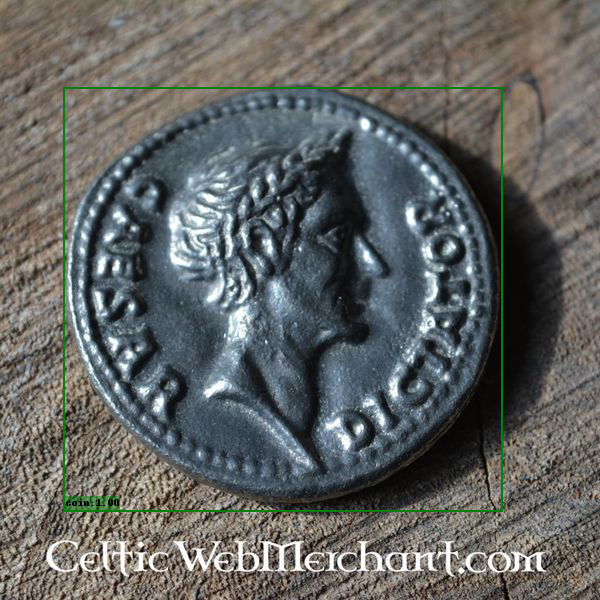

In [11]:
PIL.Image.fromarray(drawn_image)